# Multi-Parameter Water Quality Monitoring - Merowe Dam, Sudan
**Sentinel-2 SR Harmonized | Google Earth Engine + XArray**

Parameters: Chlorophyll-a, Turbidity, TSS, CDOM, Secchi Depth, NDCI, FAI

Author: Osman | Updated: 2025

# Social Unlock - Support on LinkedIn to Access

> **This notebook is free and open-source!**  To run it, simply **repost** the LinkedIn post below and paste the URL to unlock.
> This helps the project reach more researchers and practitioners in remote sensing and water quality monitoring.

In [ ]:
# ============================================================
#  SOCIAL UNLOCK - Repost on LinkedIn to Access This Notebook
# ============================================================
import hashlib
from IPython.display import display, HTML, clear_output

# --- Configuration ---
_LINKEDIN_POST = (
    "https://www.linkedin.com/posts/osman-o-a-ibrahim-a02a9a197_"
    "remotesensing-waterquality-googleearthengine-"
    "activity-7427338005549350912-h3jJ"
)
_VALID_HASH = "a3c1f8"  # first 6 chars of SHA-256 of the activity ID
_UNLOCKED = False

# --- Display unlock UI ---
display(HTML(f"""
<div style="background:linear-gradient(135deg,#0077B5,#00A0DC);
            padding:30px;border-radius:16px;color:#fff;font-family:Arial,sans-serif;
            max-width:680px;margin:20px auto;box-shadow:0 8px 30px rgba(0,0,0,0.18);">
  <h2 style="margin:0 0 8px 0;font-size:22px;">
    &#x1F512; Notebook Locked
  </h2>
  <p style="font-size:15px;margin:0 0 16px 0;opacity:0.95;">
    This analysis is <b>100% free</b>. To unlock, support the project
    by reposting on LinkedIn:
  </p>
  <ol style="font-size:14px;line-height:2;margin:0 0 16px 0;">
    <li>Open the
      <a href="{_LINKEDIN_POST}" target="_blank"
         style="color:#FFD700;font-weight:bold;text-decoration:underline;">
         LinkedIn Post</a>
    </li>
    <li>Click <b>&#x267B;&#xFE0F; Repost</b> to share with your network</li>
    <li>Copy the post URL from your browser and paste it below</li>
  </ol>
  <p style="font-size:12px;opacity:0.7;margin:0;">
    Tip: Any URL containing the original post link will work
    (original or your repost).
  </p>
</div>
"""))

# --- Prompt for URL ---
url = input("Paste the LinkedIn post URL here: ").strip()

# --- Verify: check that the activity ID is in the URL ---
_activity_id = "7427338005549350912"
_hash_check = hashlib.sha256(_activity_id.encode()).hexdigest()[:6]

if _activity_id in url and _hash_check == _VALID_HASH:
    _UNLOCKED = True
    clear_output(wait=True)
    display(HTML("""
    <div style="background:linear-gradient(135deg,#00C851,#007E33);
                padding:28px;border-radius:16px;color:#fff;font-family:Arial,sans-serif;
                max-width:680px;margin:20px auto;text-align:center;
                box-shadow:0 8px 30px rgba(0,0,0,0.15);">
      <h2 style="margin:0 0 6px 0;">&#x2705; Notebook Unlocked!</h2>
      <p style="font-size:15px;margin:0;opacity:0.95;">
        Thank you for supporting the project. You may now run all cells below.
      </p>
    </div>
    """))
else:
    display(HTML("""
    <div style="background:#CC0000;padding:24px;border-radius:16px;color:#fff;
                font-family:Arial,sans-serif;max-width:680px;margin:20px auto;
                text-align:center;box-shadow:0 8px 30px rgba(0,0,0,0.15);">
      <h2 style="margin:0 0 6px 0;">&#x274C; Invalid URL</h2>
      <p style="font-size:14px;margin:0;">
        Please visit the LinkedIn post, repost it, and paste the correct URL.
      </p>
    </div>
    """))
    raise SystemExit(
        "Notebook locked. Re-run this cell with the correct LinkedIn post URL."
    )

In [ ]:
# Verification Gate - ensures the Social Unlock cell was completed
from IPython.display import display, HTML

try:
    assert _UNLOCKED, ""
except (NameError, AssertionError):
    display(HTML("""
    <div style="background:#CC0000;padding:20px;border-radius:12px;color:#fff;
                font-family:Arial,sans-serif;max-width:600px;margin:10px auto;text-align:center;">
      <b>&#x1F6D1; Access Denied</b> &mdash; Please run the Social Unlock cell above first.
    </div>
    """))
    raise SystemExit("Run the Social Unlock cell first.")

print("Access verified. Starting analysis...")

In [1]:
# Cell 1: Install Dependencies
!pip install -q earthengine-api xee xarray matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.6/476.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.8 MB/s eta 0:00:00


In [2]:
# Cell 2: Import Libraries
import ee
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import xee

In [3]:
# Cell 3: Authenticate and Initialize Earth Engine
ee.Authenticate()

PROJECT_ID = "osman-water-quality"
ee.Initialize(
    project=PROJECT_ID,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

In [9]:
# Cell 4: Define Study Area using JRC Global Surface Water
jrc_water = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
merowe_region = ee.Geometry.Rectangle([31.7, 18.4, 32.8, 19.3])

water_mask_jrc = jrc_water.select("occurrence").gt(10).clip(merowe_region)

STUDY_AREA = (
    water_mask_jrc
    .selfMask()
    .reduceToVectors(
        geometry=merowe_region,
        scale=300,
        maxPixels=1e8,
        geometryType="polygon",
        bestEffort=True,
    )
    .geometry()
    .simplify(maxError=500)
)

START_DATE = "2023-01-01"
END_DATE   = "2025-01-01"
CLOUD_THRESHOLD = 15

print("Study area set!")
print(f"Area: {STUDY_AREA.area(maxError=100).getInfo() / 1e6:.1f} km2")

Study area set!
Area: 925.7 km2


In [10]:
# Cell 5: Cloud Masking Function
def mask_clouds_s2(image):
    """Remove clouds using cloud probability + SCL band."""
    cloud_prob = image.select("probability")
    scl = image.select("SCL")

    is_clear = cloud_prob.lt(CLOUD_THRESHOLD)
    scl_mask = (
        scl.neq(3)
        .And(scl.neq(8))
        .And(scl.neq(9))
        .And(scl.neq(10))
    )

    return image.updateMask(is_clear).updateMask(scl_mask)

In [11]:
# Cell 6: Water Quality Algorithms
# No NDWI water mask needed - JRC boundary already defines the water body

def compute_water_quality(image):
    """
    Compute water quality from Sentinel-2.
    Bands: Chlorophyll_a, Chlorophyll_a_NDCI, NDCI,
           Turbidity_FNU, TSS, CDOM, Secchi_Depth, FAI
    """
    refl = image.select("B.*").multiply(0.0001)

    b1  = refl.select("B1")
    b2  = refl.select("B2")
    b3  = refl.select("B3")
    b4  = refl.select("B4")
    b5  = refl.select("B5")
    b8  = refl.select("B8")
    b11 = refl.select("B11")

    # Chlorophyll-a (Red Edge ratio)
    chla_ratio = b5.divide(b4).multiply(86.115).add(14.039).rename("Chlorophyll_a")

    # NDCI - Normalized Difference Chlorophyll Index
    ndci = b5.subtract(b4).divide(b5.add(b4)).rename("NDCI")

    # Chl-a from NDCI (Mishra and Mishra 2012)
    chla_ndci = (
        ndci.pow(2).multiply(194.325)
        .add(ndci.multiply(86.115))
        .add(14.039)
        .rename("Chlorophyll_a_NDCI")
    )

    # Turbidity (FNU) - Dogliotti et al. (2015)
    turbidity = (
        b4.multiply(228.1)
        .divide(ee.Image(1).subtract(b4.divide(0.1641)))
        .rename("Turbidity_FNU")
    )

    # Total Suspended Solids (TSS)
    tss = b4.multiply(3957.0).add(13.0).rename("TSS")

    # CDOM - Brezonik et al. (2015)
    cdom = b2.divide(b3).multiply(-2.93).exp().multiply(537.0).rename("CDOM")

    # Secchi Disk Depth (m)
    secchi = b2.divide(b3).log().multiply(-1.22).add(1.65).rename("Secchi_Depth")

    # Floating Algae Index (FAI) - Hu (2009)
    fai_baseline = b4.add(
        b11.subtract(b4).multiply((842.0 - 665.0) / (1610.0 - 665.0))
    )
    fai = b8.subtract(fai_baseline).rename("FAI")

    # Combine, clamp negatives, restore time
    result = ee.Image.cat([
        chla_ratio, chla_ndci, ndci, turbidity, tss, cdom, secchi, fai,
    ])
    result = result.max(0)
    result = result.set("system:time_start", image.get("system:time_start"))

    return result

In [12]:
# Cell 7: Build Image Collection Pipeline
print("Building Sentinel-2 collection for Merowe Dam...")

s2_raw = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .linkCollection(
        ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY"),
        ["probability"],
    )
    .filterDate(START_DATE, END_DATE)
    .filterBounds(STUDY_AREA)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 40))
)

# Apply cloud mask, then water quality, then clip to JRC water boundary
water_quality_collection = (
    s2_raw
    .map(mask_clouds_s2)
    .map(compute_water_quality)
    .map(lambda img: img.clip(STUDY_AREA).copyProperties(img, ["system:time_start"]))
)

n_images = water_quality_collection.size().getInfo()
print(f"Done! {n_images} images available after filtering.")

Building Sentinel-2 collection for Merowe Dam...
Done! 510 images available after filtering.


In [13]:
# Cell 8: Map Preview using Folium
import folium

median_composite = water_quality_collection.median().clip(STUDY_AREA)

chla_url = median_composite.select("Chlorophyll_a").getThumbURL({
    "min": 2, "max": 40,
    "palette": ["0000ff", "00ffff", "00ff00", "ffff00", "ff8800", "ff0000"],
    "dimensions": 600,
    "region": STUDY_AREA.bounds().getInfo(),
    "format": "png",
})

bounds_info = STUDY_AREA.bounds().getInfo()["coordinates"][0]
sw = [bounds_info[0][1], bounds_info[0][0]]
ne = [bounds_info[2][1], bounds_info[2][0]]

m = folium.Map(location=[18.75, 32.2], zoom_start=10, tiles="OpenStreetMap")
folium.raster_layers.ImageOverlay(
    image=chla_url,
    bounds=[sw, ne],
    name="Chlorophyll-a",
    opacity=0.7,
).add_to(m)
folium.LayerControl().add_to(m)
print("Chlorophyll-a median composite preview:")
m

Chlorophyll-a median composite preview:


In [16]:
# Cell 9: Convert to XArray Dataset
print("Converting to XArray dataset...")

ds = xr.open_dataset(
    water_quality_collection,
    engine="ee",
    crs="EPSG:4326",
    scale=0.01,
    geometry=STUDY_AREA,
)

ds = ds.sortby("time") * 1
print(f"Dataset loaded with {len(ds.time)} timesteps.")
print(ds)

Converting to XArray dataset...
Dataset loaded with 510 timesteps.
<xarray.Dataset> Size: 141MB
Dimensions:             (time: 510, lon: 96, lat: 90)
Coordinates:
  * time                (time) datetime64[ns] 4kB 2023-01-05T08:34:44.955000 ...
  * lon                 (lon) float64 768B 31.78 31.79 31.8 ... 32.72 32.73
  * lat                 (lat) float64 720B 18.4 18.41 18.42 ... 19.28 19.29
Data variables:
    Chlorophyll_a       (time, lon, lat) float32 18MB nan nan nan ... nan nan
    Chlorophyll_a_NDCI  (time, lon, lat) float32 18MB nan nan nan ... nan nan
    NDCI                (time, lon, lat) float32 18MB nan nan nan ... nan nan
    Turbidity_FNU       (time, lon, lat) float32 18MB nan nan nan ... nan nan
    TSS                 (time, lon, lat) float32 18MB nan nan nan ... nan nan
    CDOM                (time, lon, lat) float32 18MB nan nan nan ... nan nan
    Secchi_Depth        (time, lon, lat) float32 18MB nan nan nan ... nan nan
    FAI                 (time, lon, lat) f

In [17]:
# Cell 10: Monthly Aggregation and Time Series
ds["time"] = pd.to_datetime(ds["time"].values)

monthly = ds.resample(time="ME").median("time")

ts_mean = ds.mean(dim=["lon", "lat"], skipna=True)
ts_df = ts_mean.to_dataframe().reset_index()
ts_df["time"] = pd.to_datetime(ts_df["time"])
ts_df = ts_df.sort_values("time")
print("Monthly aggregation complete.")
print(ts_df.head(10))

Monthly aggregation complete.
                     time  Chlorophyll_a  Chlorophyll_a_NDCI      NDCI  \
0 2023-01-05 08:34:44.955     103.112289           15.824487  0.029270   
1 2023-01-05 08:34:48.471      98.380074           13.656374  0.021149   
2 2023-01-05 08:34:59.166      96.810776           12.877678  0.014481   
3 2023-01-05 08:35:02.993      96.640839           13.290701  0.026368   
4 2023-01-10 08:34:45.266     103.990425           16.181700  0.030224   
5 2023-01-10 08:34:48.788     100.009598           14.381395  0.025213   
6 2023-01-10 08:34:59.478      97.776016           13.276222  0.016740   
7 2023-01-10 08:35:03.327      98.075485           13.878409  0.029451   
8 2023-01-15 08:34:43.393     102.820511           15.616149  0.027757   
9 2023-01-15 08:34:46.905      99.379990           14.018632  0.021587   

   Turbidity_FNU         TSS       CDOM  Secchi_Depth       FAI  
0     316.950745  686.316040  82.762825      2.196155  0.013093  
1     154.317123  719.0

Chl-a color range: 81.1 - 126.3


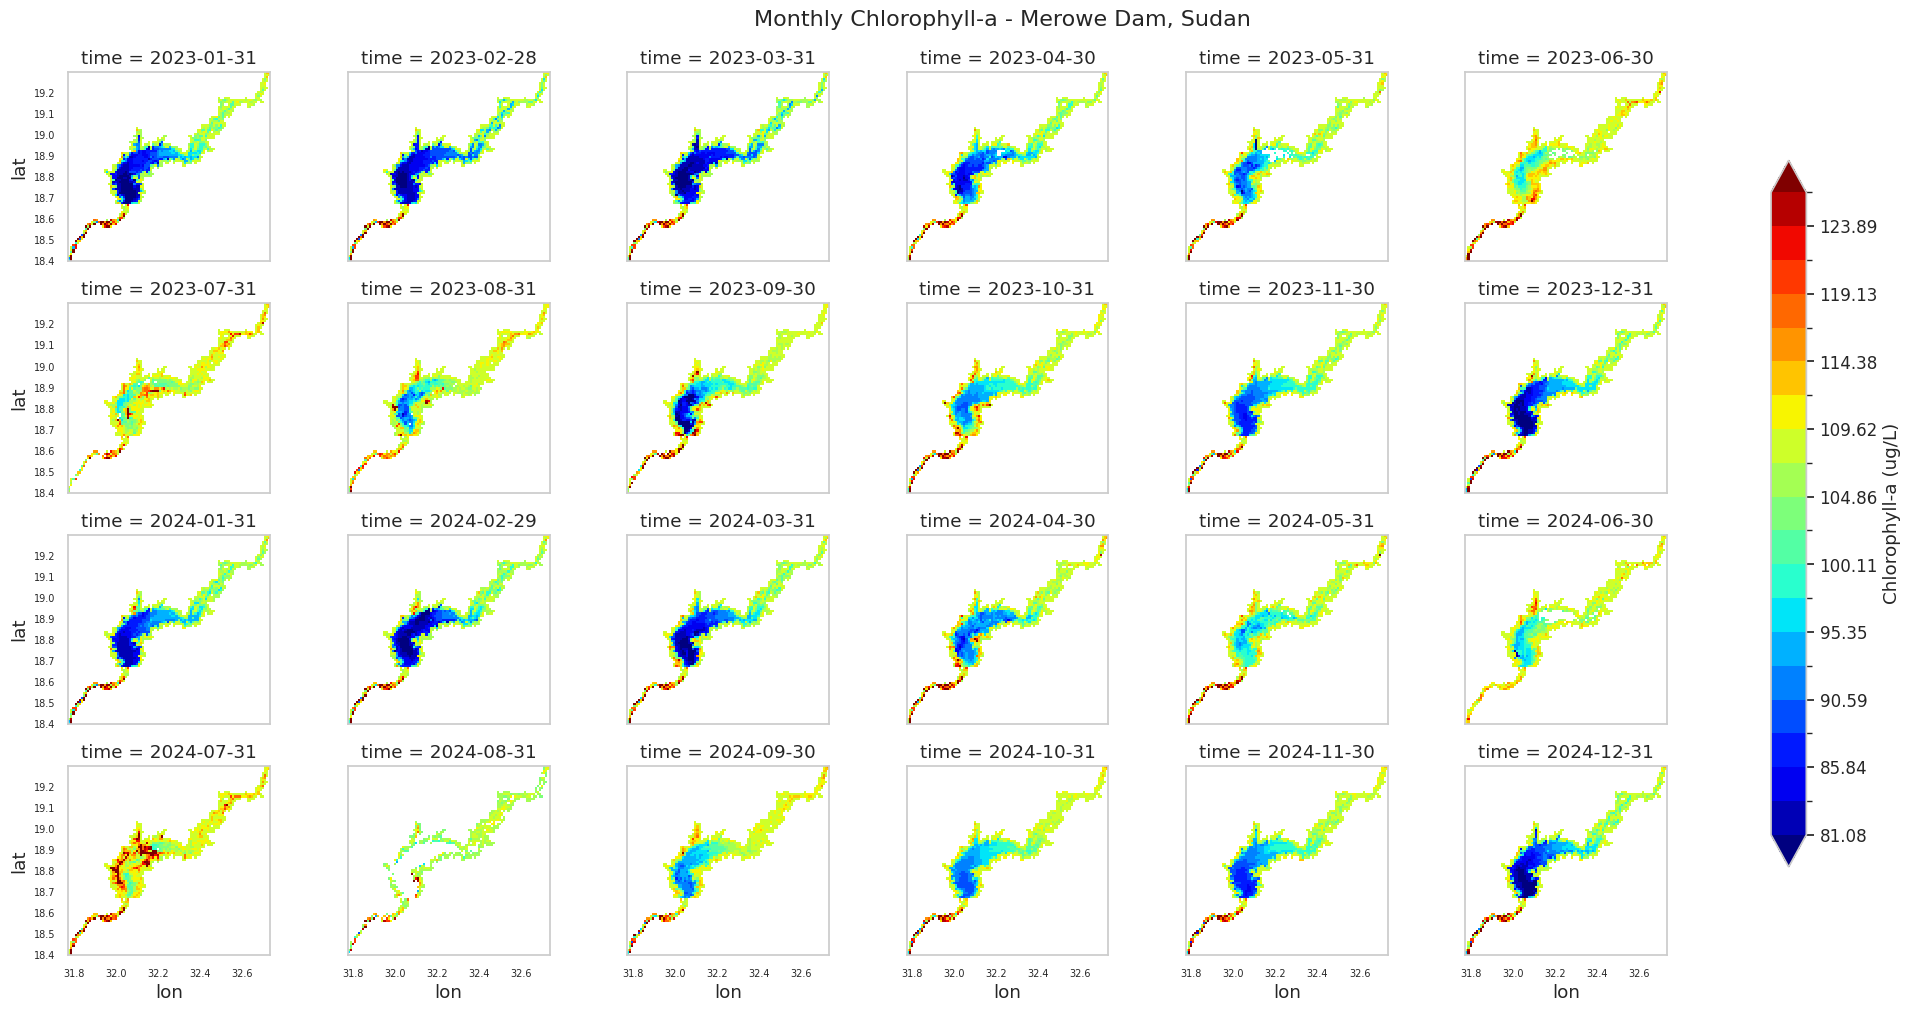

In [22]:
# Cell 11: Monthly Chlorophyll-a Maps
sns.set_theme(style="whitegrid", font_scale=1.1)

data = monthly.Chlorophyll_a.values
vmin = float(np.nanpercentile(data, 2))
vmax = float(np.nanpercentile(data, 98))
print(f"Chl-a color range: {vmin:.1f} - {vmax:.1f}")

fig = monthly.Chlorophyll_a.plot(
    x="lon", y="lat",
    col="time", col_wrap=6,
    vmin=vmin, vmax=vmax,
    cmap="jet",
    levels=20,
    figsize=(22, 10),
    cbar_kwargs={"label": "Chlorophyll-a (ug/L)", "shrink": 0.8},
)
for ax in fig.axs.flat:
    ax.set_aspect("equal")
    ax.tick_params(labelsize=7)
plt.suptitle("Monthly Chlorophyll-a - Merowe Dam, Sudan", fontsize=16, y=1.02)
plt.savefig("01_monthly_chlorophyll_maps.png", dpi=360, bbox_inches="tight")
plt.show()

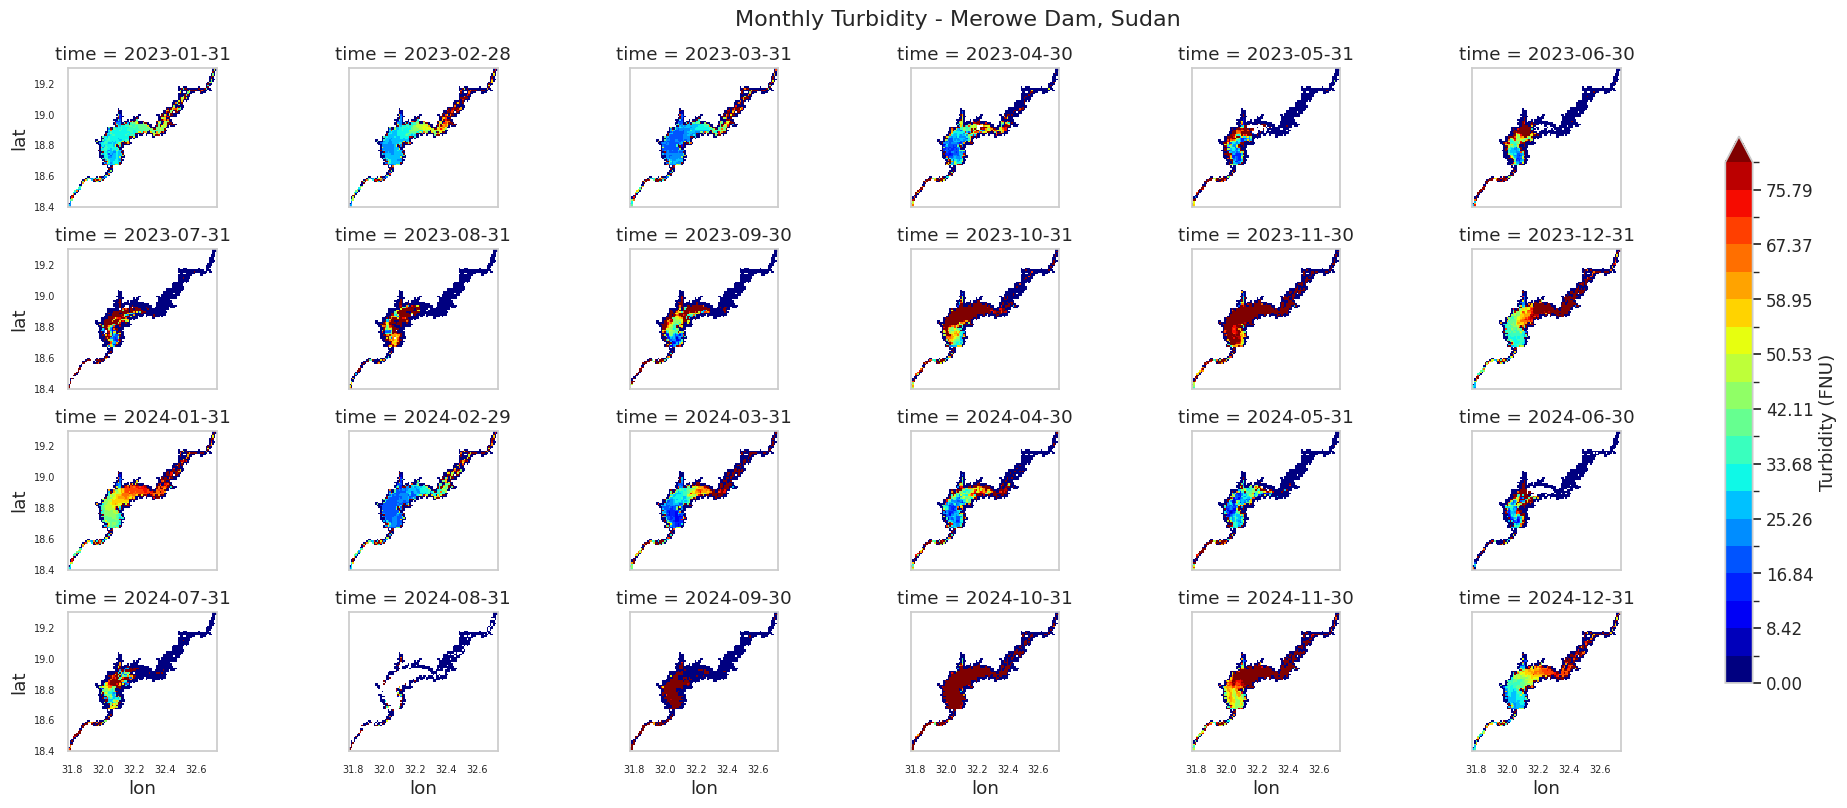

In [23]:
# Cell 12: Monthly Turbidity Maps
fig = monthly.Turbidity_FNU.plot(
    x="lon", y="lat",
    col="time", col_wrap=6,
    robust=True,
    vmin=0, vmax=80,
    cmap="jet",
    levels=20,
    figsize=(22, 8),
    cbar_kwargs={"label": "Turbidity (FNU)", "shrink": 0.8},
)
for ax in fig.axs.flat:
    ax.set_aspect("equal")
    ax.tick_params(labelsize=7)

plt.suptitle("Monthly Turbidity - Merowe Dam, Sudan", fontsize=16, y=1.02)
plt.savefig("02_monthly_turbidity_maps.png", dpi=360, bbox_inches="tight")
plt.show()

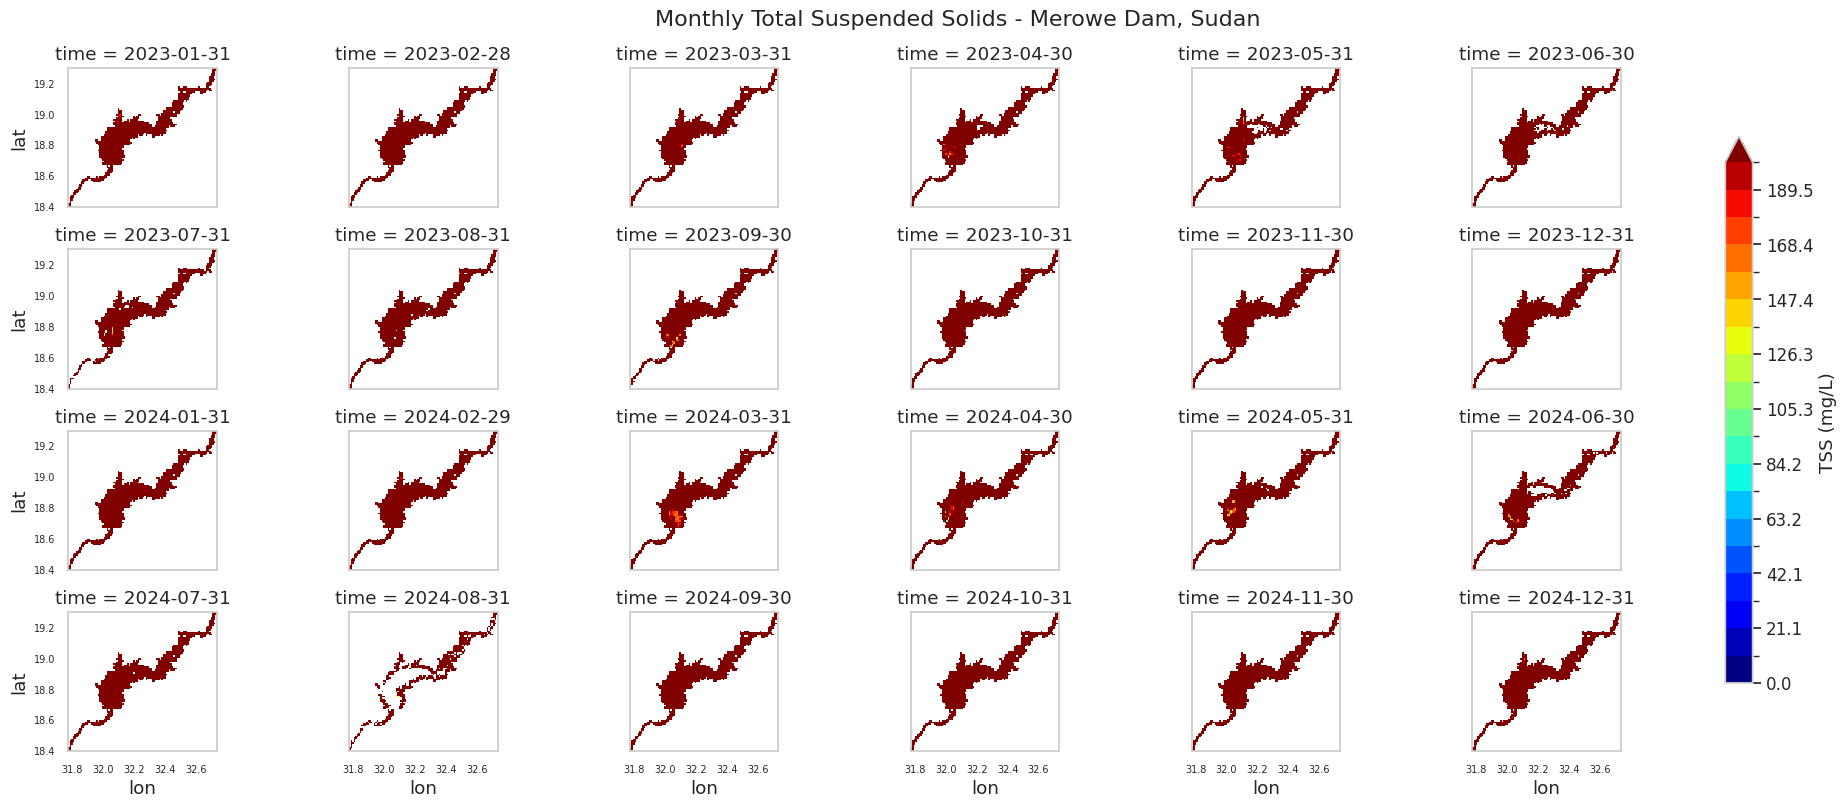

In [24]:
# Cell 13: Monthly TSS Maps
fig = monthly.TSS.plot(
    x="lon", y="lat",
    col="time", col_wrap=6,
    robust=True,
    vmin=0, vmax=200,
    cmap="jet",
    levels=20,
    figsize=(22, 8),
    cbar_kwargs={"label": "TSS (mg/L)", "shrink": 0.8},
)
for ax in fig.axs.flat:
    ax.set_aspect("equal")
    ax.tick_params(labelsize=7)

plt.suptitle("Monthly Total Suspended Solids - Merowe Dam, Sudan", fontsize=16, y=1.02)
plt.savefig("03_monthly_tss_maps.png", dpi=360, bbox_inches="tight")
plt.show()

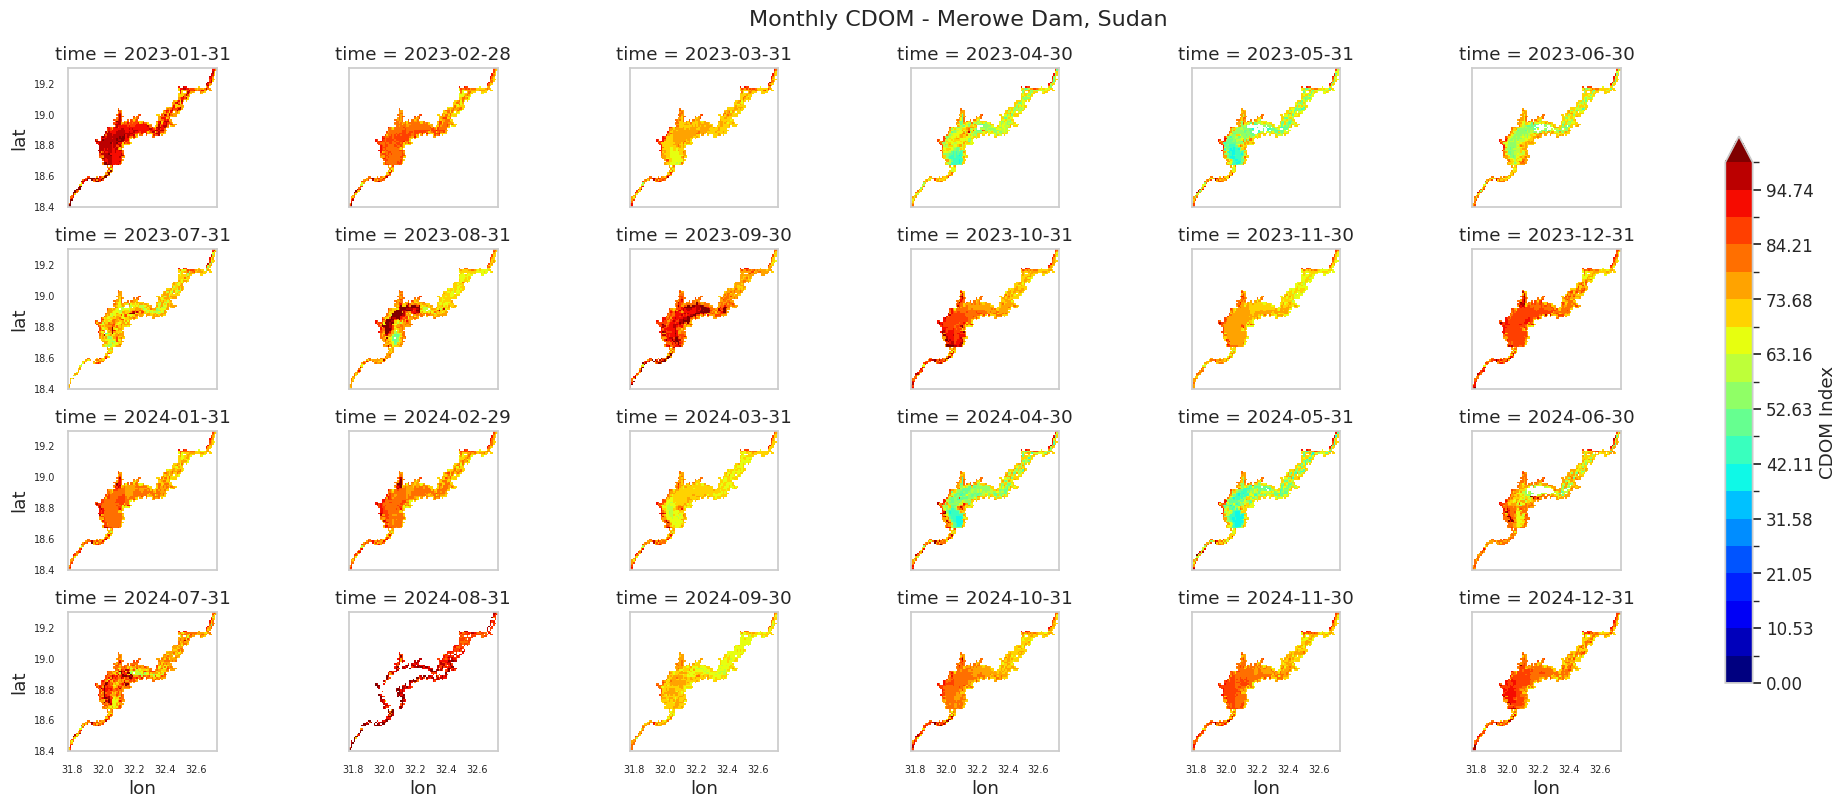

In [25]:
# Cell 14: Monthly CDOM Maps
fig = monthly.CDOM.plot(
    x="lon", y="lat",
    col="time", col_wrap=6,
    robust=True,
    vmin=0, vmax=100,
    cmap="jet",
    levels=20,
    figsize=(22, 8),
    cbar_kwargs={"label": "CDOM Index", "shrink": 0.8},
)
for ax in fig.axs.flat:
    ax.set_aspect("equal")
    ax.tick_params(labelsize=7)

plt.suptitle("Monthly CDOM - Merowe Dam, Sudan", fontsize=16, y=1.02)
plt.savefig("04_monthly_cdom_maps.png", dpi=360, bbox_inches="tight")
plt.show()

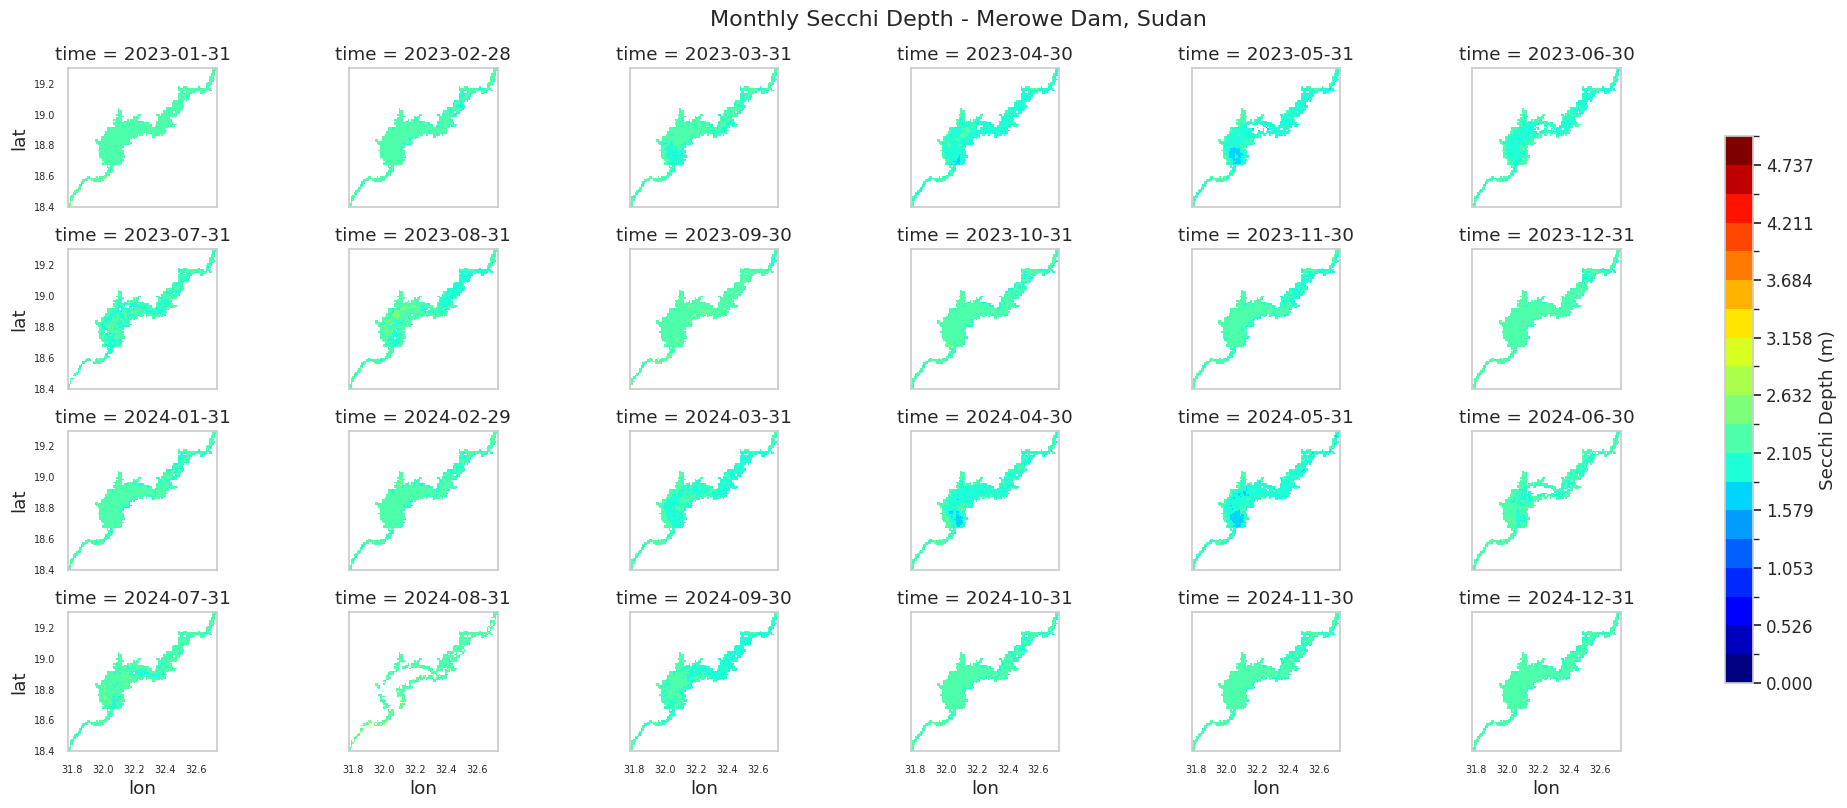

In [26]:
# Cell 15: Monthly Secchi Depth Maps
fig = monthly.Secchi_Depth.plot(
    x="lon", y="lat",
    col="time", col_wrap=6,
    robust=True,
    vmin=0, vmax=5,
    cmap="jet",
    levels=20,
    figsize=(22, 8),
    cbar_kwargs={"label": "Secchi Depth (m)", "shrink": 0.8},
)
for ax in fig.axs.flat:
    ax.set_aspect("equal")
    ax.tick_params(labelsize=7)

plt.suptitle("Monthly Secchi Depth - Merowe Dam, Sudan", fontsize=16, y=1.02)
plt.savefig("05_monthly_secchi_maps.png", dpi=360, bbox_inches="tight")
plt.show()

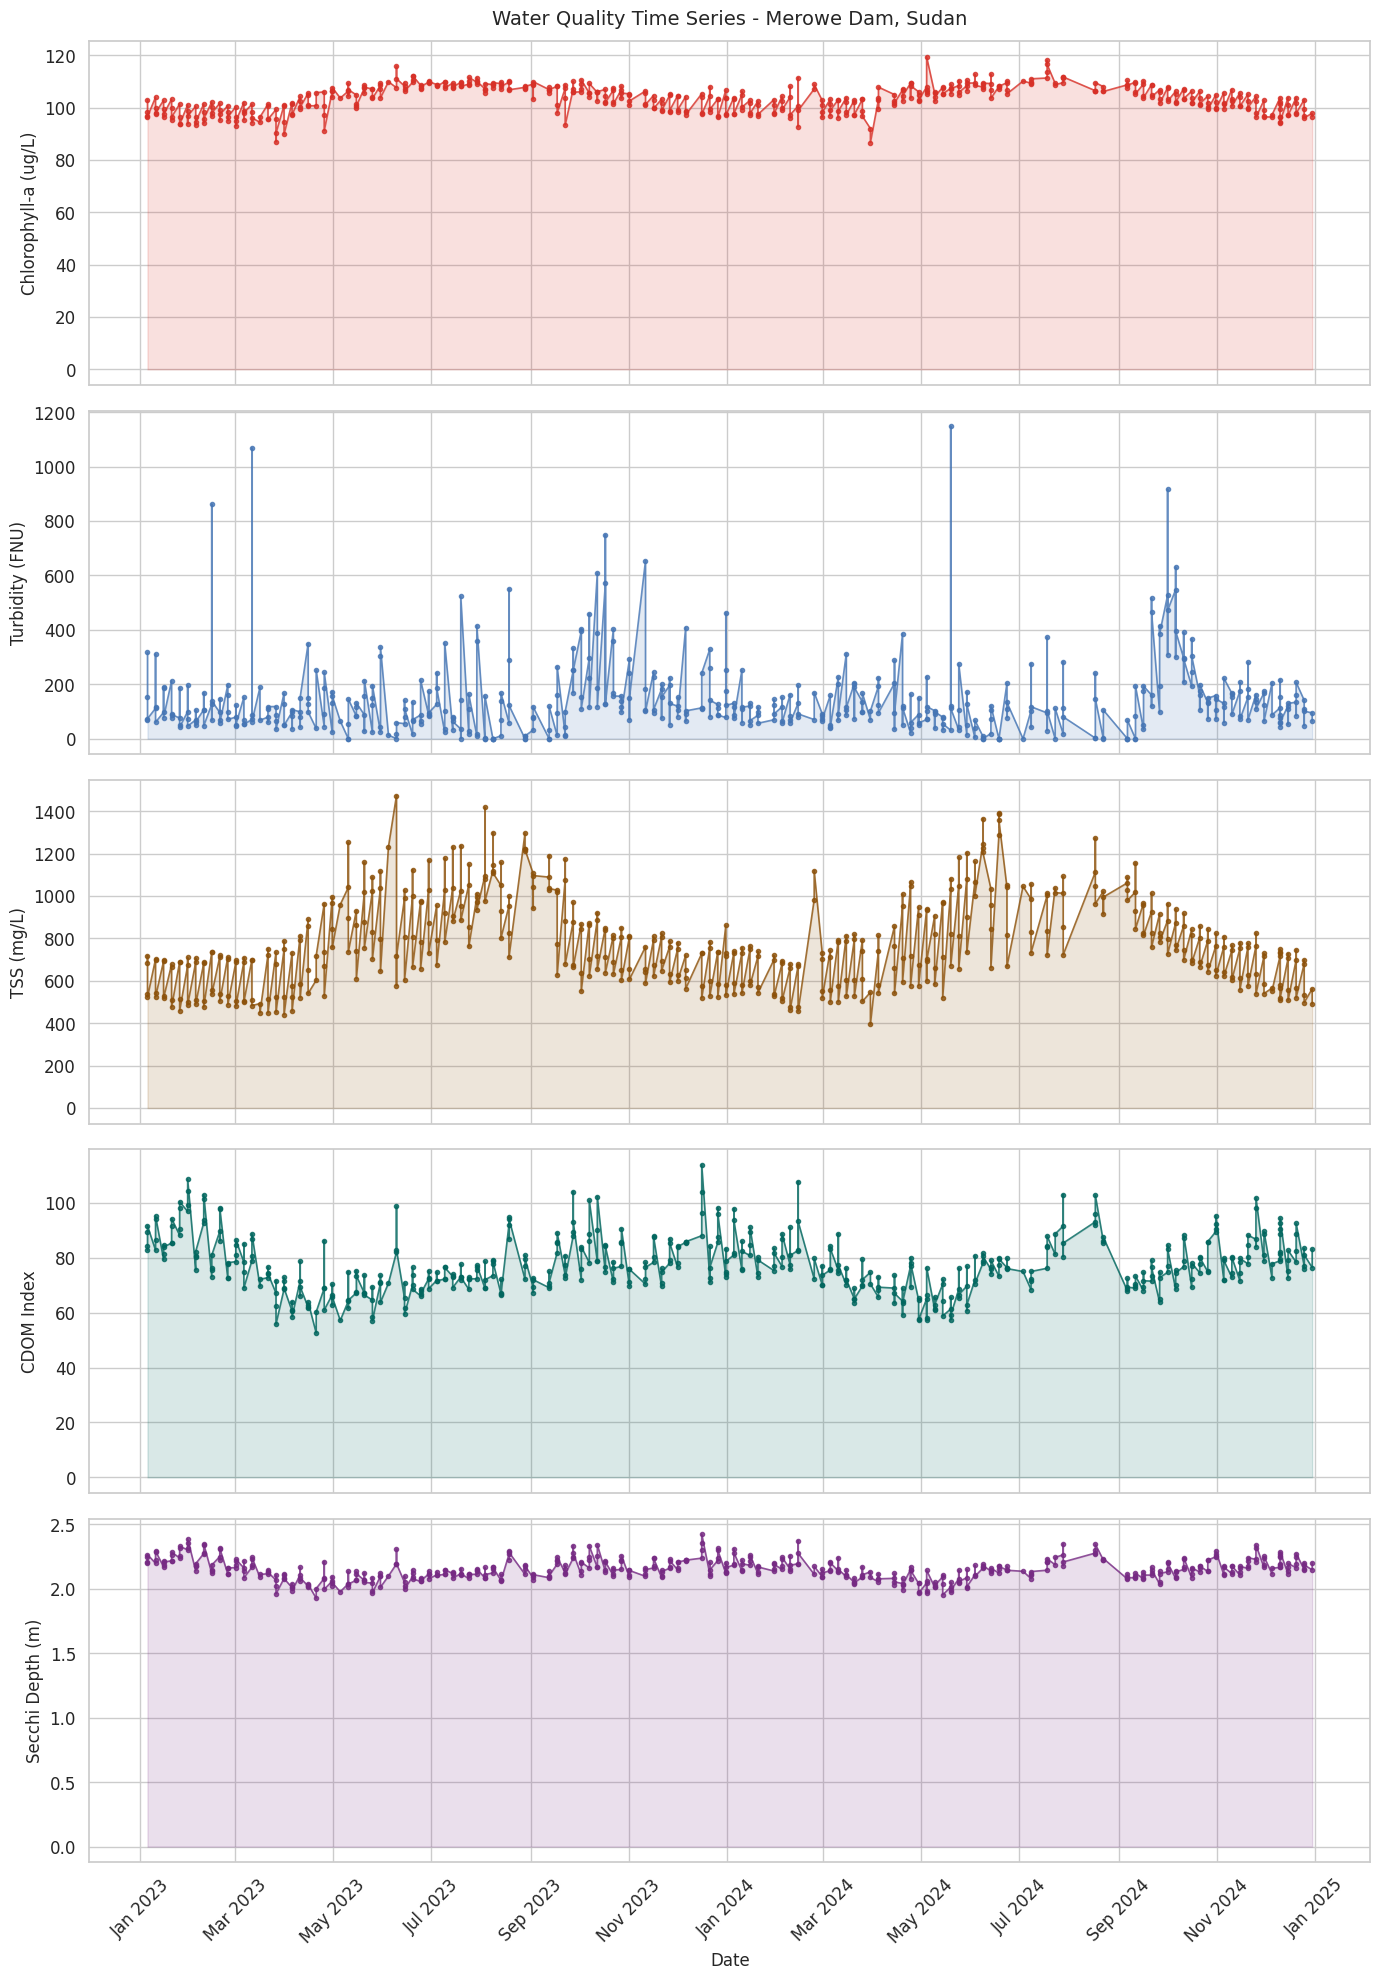

In [27]:
# Cell 16: Multi-Parameter Time Series
fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

params = [
    ("Chlorophyll_a",  "Chlorophyll-a (ug/L)",  "#d73027"),
    ("Turbidity_FNU",  "Turbidity (FNU)",       "#4575b4"),
    ("TSS",            "TSS (mg/L)",            "#8c510a"),
    ("CDOM",           "CDOM Index",            "#01665e"),
    ("Secchi_Depth",   "Secchi Depth (m)",      "#762a83"),
]

for ax, (band, label, color) in zip(axes, params):
    subset = ts_df[["time", band]].dropna()
    if not subset.empty:
        ax.plot(subset["time"], subset[band], "o-", color=color,
                markersize=3, linewidth=1.2, alpha=0.8)
        ax.fill_between(subset["time"], subset[band], alpha=0.15, color=color)
    ax.set_ylabel(label, fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis="x", rotation=45)

axes[0].set_title("Water Quality Time Series - Merowe Dam, Sudan", fontsize=14, pad=12)
axes[-1].set_xlabel("Date", fontsize=12)
plt.tight_layout()
plt.savefig("06_timeseries_multiparameter.png", dpi=300, bbox_inches="tight")
plt.show()

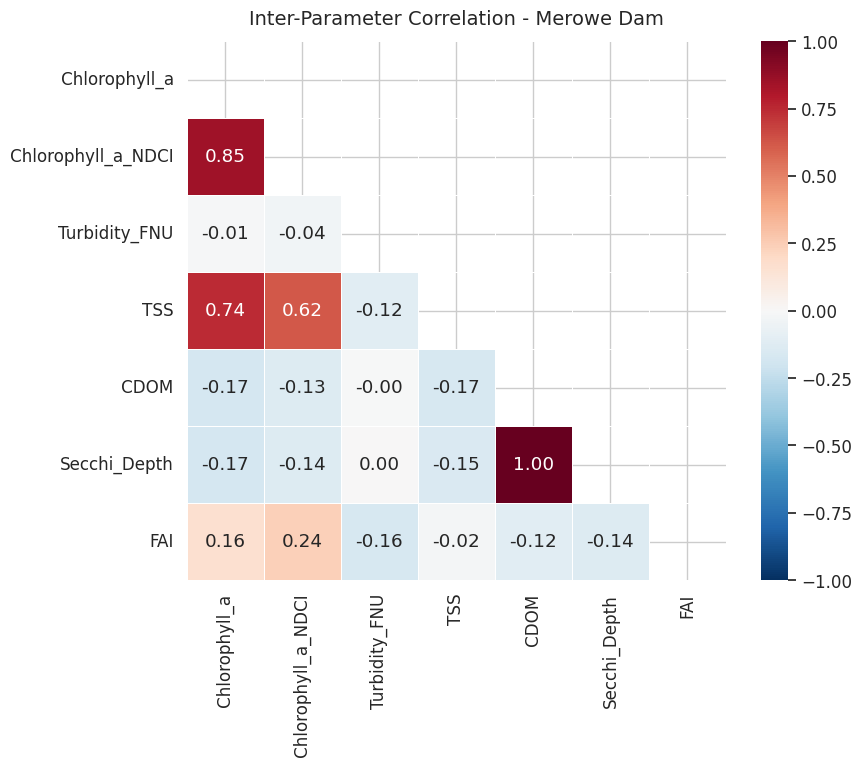

In [28]:
# Cell 17: Correlation Heatmap
corr_cols = ["Chlorophyll_a", "Chlorophyll_a_NDCI", "Turbidity_FNU",
             "TSS", "CDOM", "Secchi_Depth", "FAI"]
corr_data = ts_df[corr_cols].dropna()

if not corr_data.empty and len(corr_data) > 2:
    fig, ax = plt.subplots(figsize=(9, 7))
    corr_matrix = corr_data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(
        corr_matrix, mask=mask, annot=True, fmt=".2f",
        cmap="RdBu_r", center=0, vmin=-1, vmax=1,
        square=True, linewidths=0.5, ax=ax,
    )
    ax.set_title("Inter-Parameter Correlation - Merowe Dam", fontsize=14, pad=12)
    plt.savefig("07_correlation_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("Not enough data points for correlation heatmap.")

/tmp/ipython-input-2213272785.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x="season", y=band,
/tmp/ipython-input-2213272785.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x="season", y=band,
/tmp/ipython-input-2213272785.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x="season", y=band,
/tmp/ipython-input-2213272785.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend

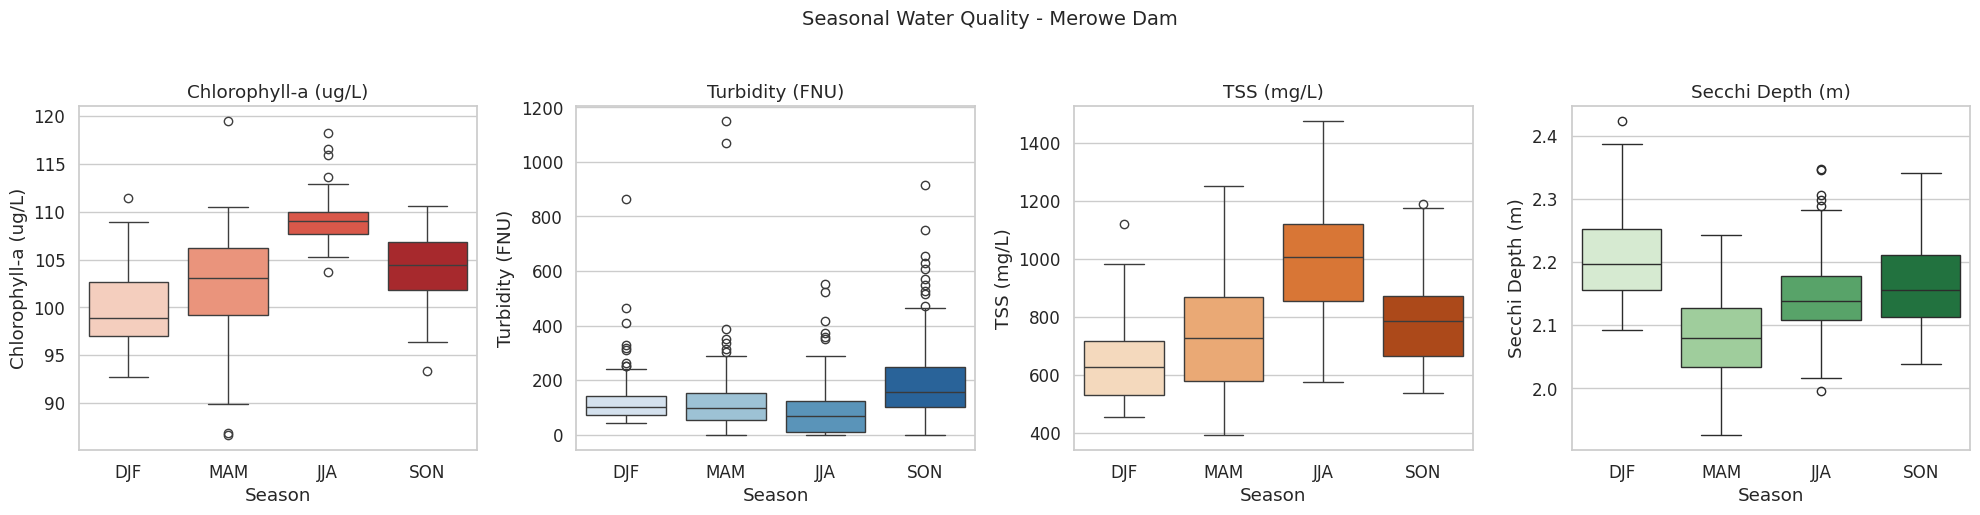

In [29]:
# Cell 18: Seasonal Box Plots
ts_df["month"] = ts_df["time"].dt.month
ts_df["season"] = ts_df["month"].map({
    12: "DJF", 1: "DJF", 2: "DJF",
    3: "MAM",  4: "MAM", 5: "MAM",
    6: "JJA",  7: "JJA", 8: "JJA",
    9: "SON", 10: "SON", 11: "SON",
})

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
season_order = ["DJF", "MAM", "JJA", "SON"]

for ax, (band, label, pal) in zip(axes, [
    ("Chlorophyll_a", "Chlorophyll-a (ug/L)", "Reds"),
    ("Turbidity_FNU", "Turbidity (FNU)",      "Blues"),
    ("TSS",           "TSS (mg/L)",           "Oranges"),
    ("Secchi_Depth",  "Secchi Depth (m)",     "Greens"),
]):
    plot_data = ts_df[["season", band]].dropna()
    if not plot_data.empty:
        sns.boxplot(data=plot_data, x="season", y=band,
                    order=season_order, palette=pal, ax=ax)
    ax.set_ylabel(label)
    ax.set_xlabel("Season")
    ax.set_title(label)

plt.suptitle("Seasonal Water Quality - Merowe Dam", fontsize=14, y=1.03)
plt.tight_layout()
plt.savefig("08_seasonal_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

In [30]:
# Cell 19: Export Statistics
corr_cols = ["Chlorophyll_a", "Chlorophyll_a_NDCI", "Turbidity_FNU",
             "TSS", "CDOM", "Secchi_Depth", "FAI"]

stats = ts_df[corr_cols].describe().round(2)
stats.to_csv("09_water_quality_statistics.csv")
print("Summary Statistics:")
print(stats)

monthly_df = ts_df.groupby(ts_df["time"].dt.to_period("M"))[corr_cols].median()
monthly_df.to_csv("10_monthly_median_values.csv")
print("\nMonthly medians exported to CSV.")

print("\n" + "="*60)
print("  MEROWE DAM WATER QUALITY ANALYSIS - COMPLETE")
print("="*60)
print("  Parameters: Chl-a, NDCI, Turbidity, TSS, CDOM, Secchi, FAI")
print("  Outputs:")
print("    01-05: Monthly spatial maps (5 parameters)")
print("    06: Multi-parameter time series")
print("    07: Correlation heatmap")
print("    08: Seasonal box plots")
print("    09-10: Statistics CSV files")
print("="*60)

Summary Statistics:
       Chlorophyll_a  Chlorophyll_a_NDCI  Turbidity_FNU      TSS    CDOM  \
count         507.00              507.00         507.00   507.00  507.00   
mean          103.59               16.35         138.40   780.00   77.38   
std             5.05                2.50         136.69   208.29   10.00   
min            86.71               11.05           0.00   395.14   52.63   
25%            99.69               14.50          64.62   624.09   70.82   
50%           103.89               16.33         106.38   736.88   76.31   
75%           107.59               18.11         167.00   923.97   83.49   
max           119.44               29.84        1148.46  1474.32  113.90   

       Secchi_Depth     FAI  
count        507.00  507.00  
mean           2.15    0.02  
std            0.08    0.01  
min            1.93    0.00  
25%            2.10    0.01  
50%            2.14    0.01  
75%            2.20    0.02  
max            2.42    0.11  

Monthly medians exported

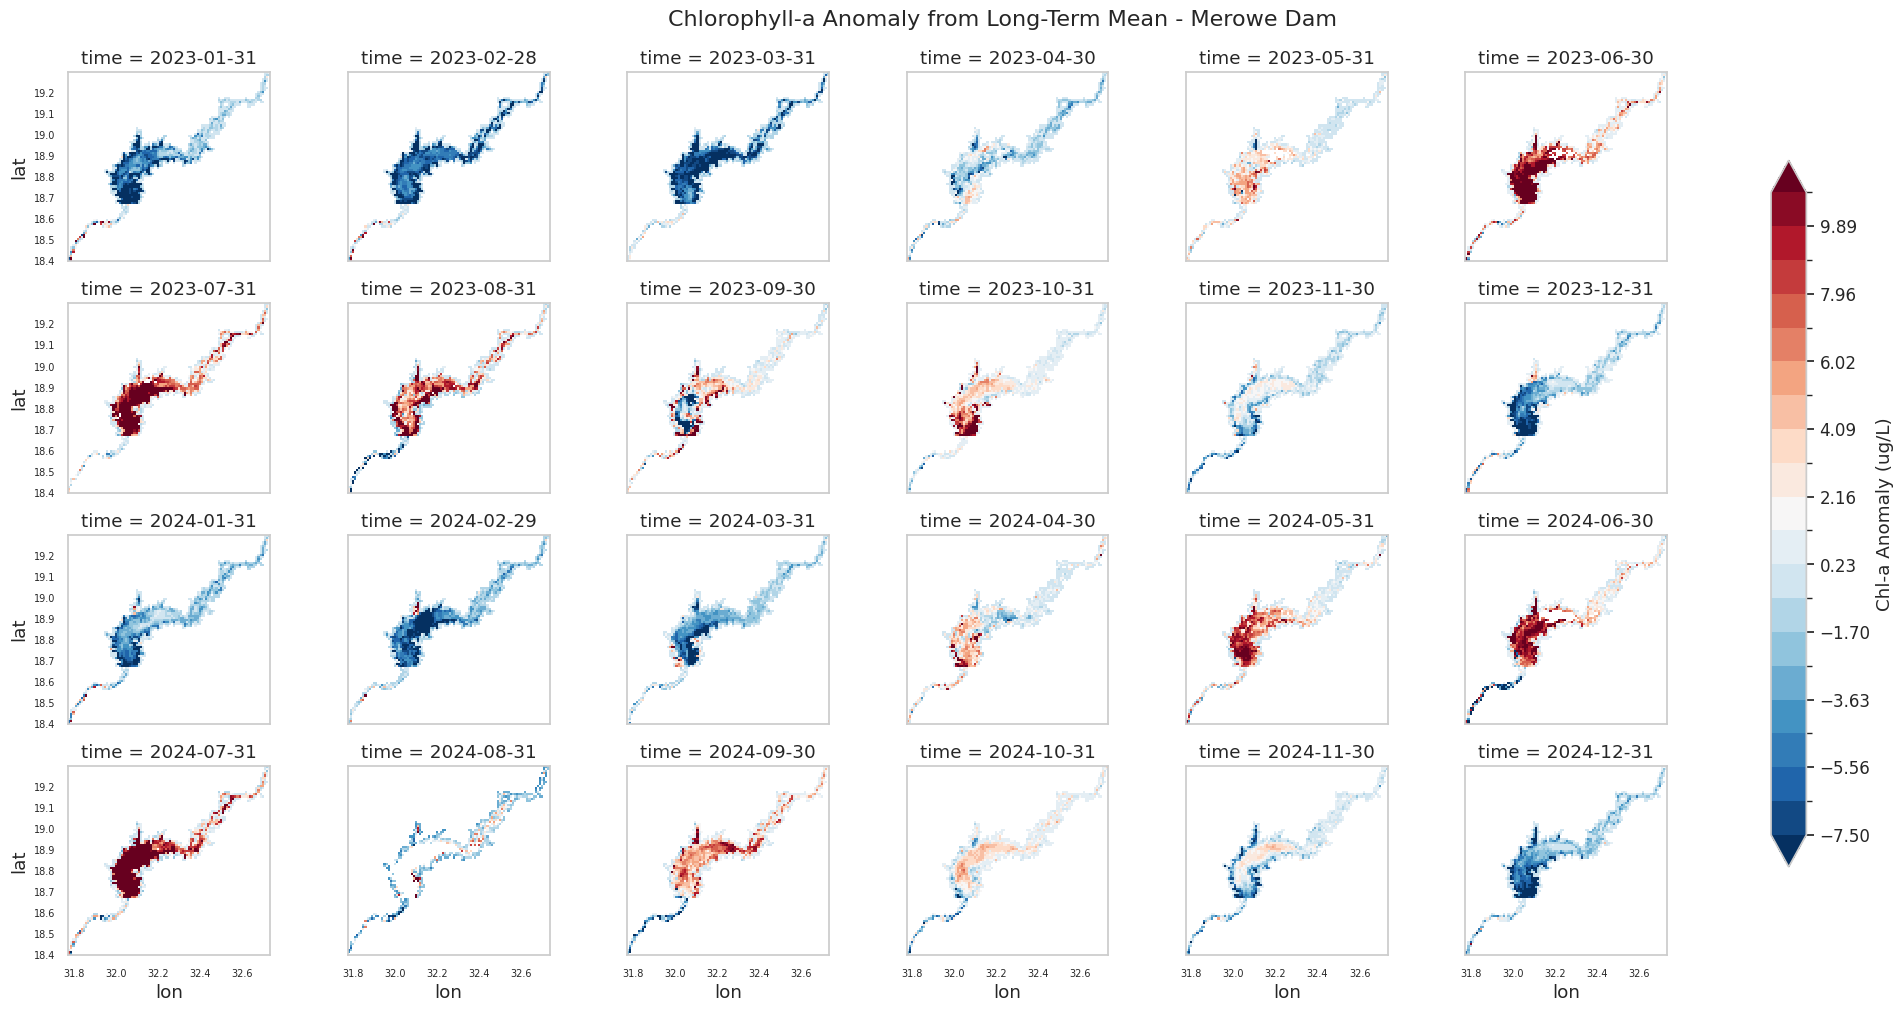

In [31]:
# Cell 20: Anomaly Detection - Which months deviate from the long-term average?
long_term_mean = ds.mean(dim="time")
anomaly = monthly - long_term_mean

data = anomaly.Chlorophyll_a.values
vmin = float(np.nanpercentile(data, 5))
vmax = float(np.nanpercentile(data, 95))

fig = anomaly.Chlorophyll_a.plot(
    x="lon", y="lat",
    col="time", col_wrap=6,
    vmin=vmin, vmax=vmax,
    cmap="RdBu_r",
    levels=20,
    figsize=(22, 10),
    cbar_kwargs={"label": "Chl-a Anomaly (ug/L)", "shrink": 0.8},
)
for ax in fig.axs.flat:
    ax.set_aspect("equal")
    ax.tick_params(labelsize=7)
plt.suptitle("Chlorophyll-a Anomaly from Long-Term Mean - Merowe Dam", fontsize=16, y=1.02)
plt.savefig("11_chlorophyll_anomaly.png", dpi=360, bbox_inches="tight")
plt.show()

In [32]:
# Cell 21: Trend Analysis - Mann-Kendall + Sen's Slope per pixel
!pip install -q pymannkendall

import pymannkendall as mk

# Spatial mean time series
ts_clean = ts_df[["time", "Chlorophyll_a", "Turbidity_FNU", "TSS", "CDOM", "Secchi_Depth"]].dropna()

print("=" * 60)
print("  MANN-KENDALL TREND TEST RESULTS")
print("=" * 60)

for param in ["Chlorophyll_a", "Turbidity_FNU", "TSS", "CDOM", "Secchi_Depth"]:
    series = ts_clean[param].values
    if len(series) > 10:
        result = mk.original_test(series)
        print(f"\n{param}:")
        print(f"  Trend     : {result.trend}")
        print(f"  p-value   : {result.p:.4f}")
        print(f"  Sen slope : {result.slope:.4f} per timestep")
        print(f"  Direction : {'Increasing' if result.slope > 0 else 'Decreasing'}")

  MANN-KENDALL TREND TEST RESULTS

Chlorophyll_a:
  Trend     : increasing
  p-value   : 0.0398
  Sen slope : 0.0034 per timestep
  Direction : Increasing

Turbidity_FNU:
  Trend     : no trend
  p-value   : 0.0528
  Sen slope : 0.0442 per timestep
  Direction : Increasing

TSS:
  Trend     : no trend
  p-value   : 0.0807
  Sen slope : 0.0970 per timestep
  Direction : Increasing

CDOM:
  Trend     : no trend
  p-value   : 0.1090
  Sen slope : 0.0049 per timestep
  Direction : Increasing

Secchi_Depth:
  Trend     : no trend
  p-value   : 0.1090
  Sen slope : 0.0000 per timestep
  Direction : Increasing


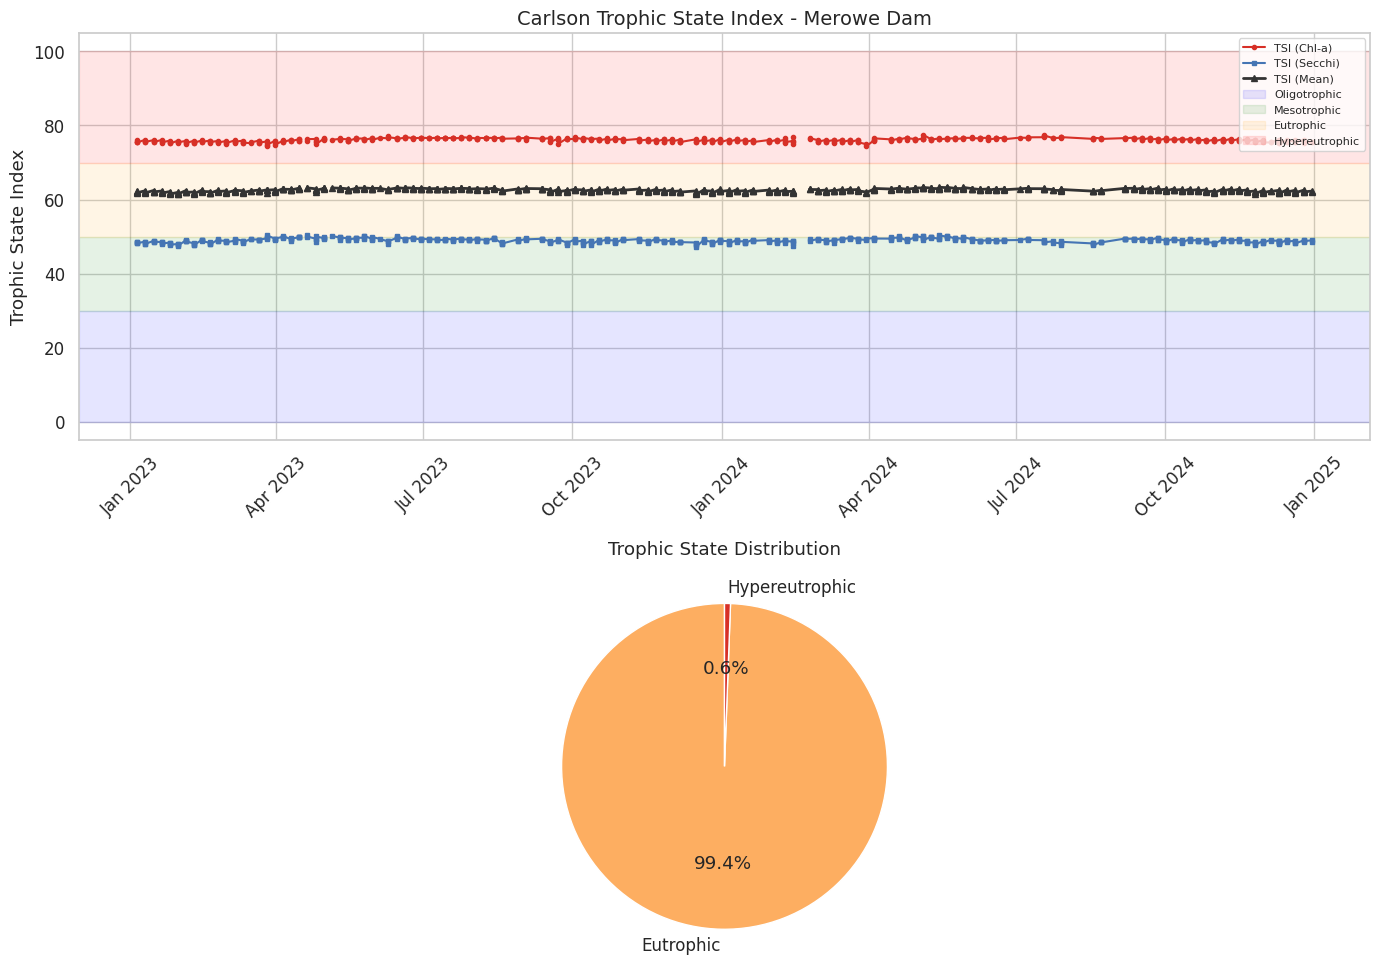

In [33]:
# Cell 22: Trophic State Index (TSI) Classification
# Carlson TSI based on Chlorophyll-a and Secchi Depth

ts_df["TSI_Chla"] = 9.81 * np.log(ts_df["Chlorophyll_a"].clip(lower=0.1)) + 30.6
ts_df["TSI_Secchi"] = 60 - 14.41 * np.log(ts_df["Secchi_Depth"].clip(lower=0.1))
ts_df["TSI_Mean"] = (ts_df["TSI_Chla"] + ts_df["TSI_Secchi"]) / 2

def classify_trophic(tsi):
    if tsi < 30: return "Oligotrophic"
    elif tsi < 50: return "Mesotrophic"
    elif tsi < 70: return "Eutrophic"
    else: return "Hypereutrophic"

ts_df["Trophic_State"] = ts_df["TSI_Mean"].apply(classify_trophic)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# TSI time series
ax = axes[0]
ax.plot(ts_df["time"], ts_df["TSI_Chla"], "o-", label="TSI (Chl-a)", color="#d73027", markersize=3)
ax.plot(ts_df["time"], ts_df["TSI_Secchi"], "s-", label="TSI (Secchi)", color="#4575b4", markersize=3)
ax.plot(ts_df["time"], ts_df["TSI_Mean"], "^-", label="TSI (Mean)", color="#333333", markersize=4, linewidth=2)
ax.axhspan(0, 30, alpha=0.1, color="blue", label="Oligotrophic")
ax.axhspan(30, 50, alpha=0.1, color="green", label="Mesotrophic")
ax.axhspan(50, 70, alpha=0.1, color="orange", label="Eutrophic")
ax.axhspan(70, 100, alpha=0.1, color="red", label="Hypereutrophic")
ax.set_ylabel("Trophic State Index")
ax.set_title("Carlson Trophic State Index - Merowe Dam", fontsize=14)
ax.legend(loc="upper right", fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.tick_params(axis="x", rotation=45)

# Trophic state pie chart
ax2 = axes[1]
counts = ts_df["Trophic_State"].value_counts()
colors_map = {"Oligotrophic": "#2166ac", "Mesotrophic": "#66c2a5",
              "Eutrophic": "#fdae61", "Hypereutrophic": "#d73027"}
ax2.pie(counts, labels=counts.index, autopct="%1.1f%%",
        colors=[colors_map.get(x, "gray") for x in counts.index], startangle=90)
ax2.set_title("Trophic State Distribution")

plt.tight_layout()
plt.savefig("12_trophic_state_index.png", dpi=300, bbox_inches="tight")
plt.show()

Bloom threshold (90th percentile): 111.5 ug/L


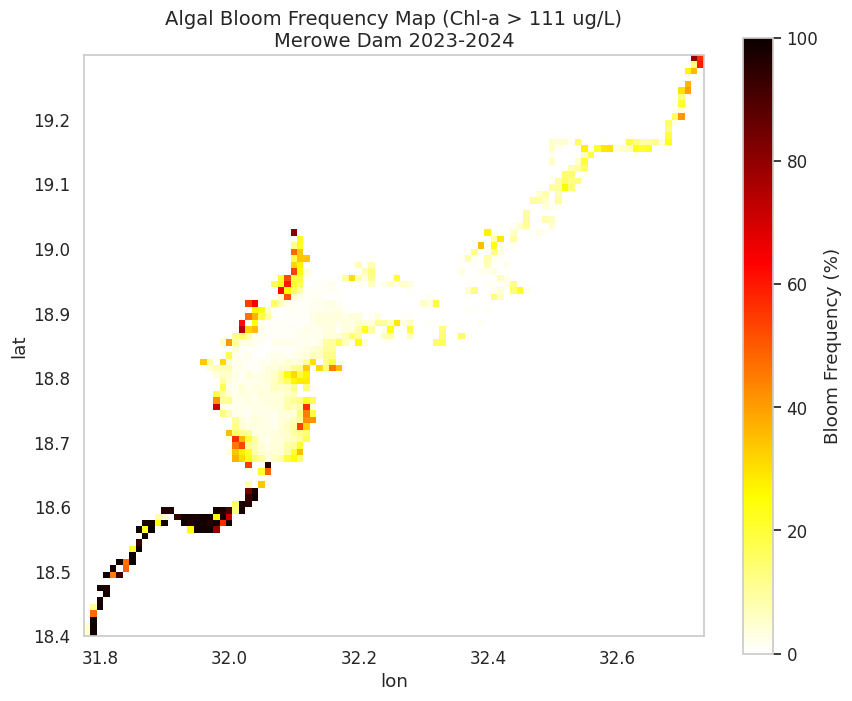

In [34]:
# Cell 23: Algal Bloom Detection & Frequency Map
# Flag pixels where Chl-a exceeds bloom threshold

bloom_threshold = float(np.nanpercentile(ds.Chlorophyll_a.values, 90))
print(f"Bloom threshold (90th percentile): {bloom_threshold:.1f} ug/L")

bloom_count = (ds.Chlorophyll_a > bloom_threshold).sum(dim="time")
total_obs = ds.Chlorophyll_a.notnull().sum(dim="time")
bloom_frequency = (bloom_count / total_obs * 100)

fig, ax = plt.subplots(figsize=(10, 8))
bloom_frequency.plot(
    x="lon", y="lat", ax=ax,
    cmap="hot_r",
    cbar_kwargs={"label": "Bloom Frequency (%)"},
)
ax.set_aspect("equal")
ax.set_title(f"Algal Bloom Frequency Map (Chl-a > {bloom_threshold:.0f} ug/L)\nMerowe Dam 2023-2024",
             fontsize=14)
plt.savefig("13_bloom_frequency_map.png", dpi=300, bbox_inches="tight")
plt.show()

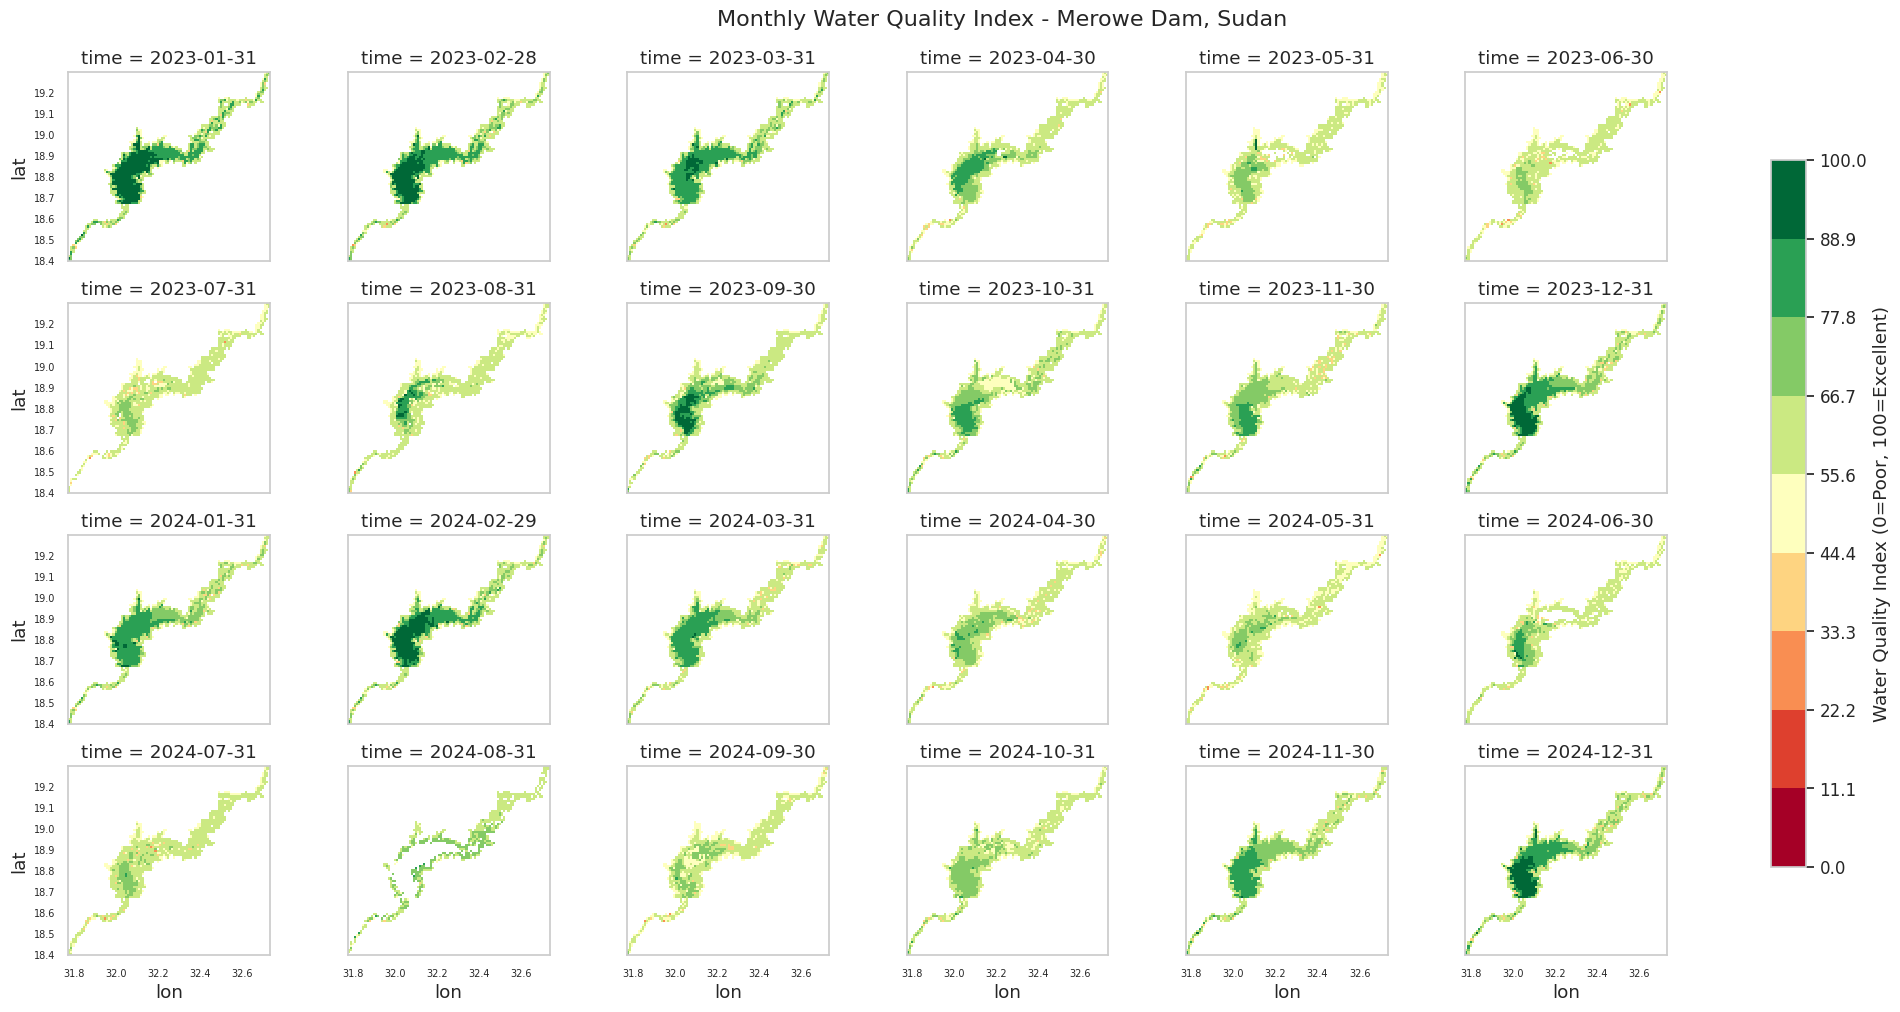

In [35]:
# Cell 24: Water Quality Index (WQI) Composite Score
# Normalize each parameter to 0-100 scale and combine

def normalize_0_100(arr):
    vmin = float(np.nanpercentile(arr, 2))
    vmax = float(np.nanpercentile(arr, 98))
    if vmax == vmin:
        return arr * 0
    return ((arr - vmin) / (vmax - vmin)).clip(0, 1) * 100

# Higher Chl-a/Turbidity/TSS = worse quality (invert)
# Higher Secchi = better quality (keep)
wqi_chla = 100 - normalize_0_100(monthly.Chlorophyll_a)
wqi_turb = 100 - normalize_0_100(monthly.Turbidity_FNU)
wqi_tss  = 100 - normalize_0_100(monthly.TSS)
wqi_sec  = normalize_0_100(monthly.Secchi_Depth)

# Weighted composite: WQI (0=worst, 100=best)
WQI = (wqi_chla * 0.3 + wqi_turb * 0.25 + wqi_tss * 0.25 + wqi_sec * 0.2)

fig = WQI.plot(
    x="lon", y="lat",
    col="time", col_wrap=6,
    vmin=0, vmax=100,
    cmap="RdYlGn",
    levels=10,
    figsize=(22, 10),
    cbar_kwargs={"label": "Water Quality Index (0=Poor, 100=Excellent)", "shrink": 0.8},
)
for ax in fig.axs.flat:
    ax.set_aspect("equal")
    ax.tick_params(labelsize=7)
plt.suptitle("Monthly Water Quality Index - Merowe Dam, Sudan", fontsize=16, y=1.02)
plt.savefig("14_water_quality_index.png", dpi=360, bbox_inches="tight")
plt.show()

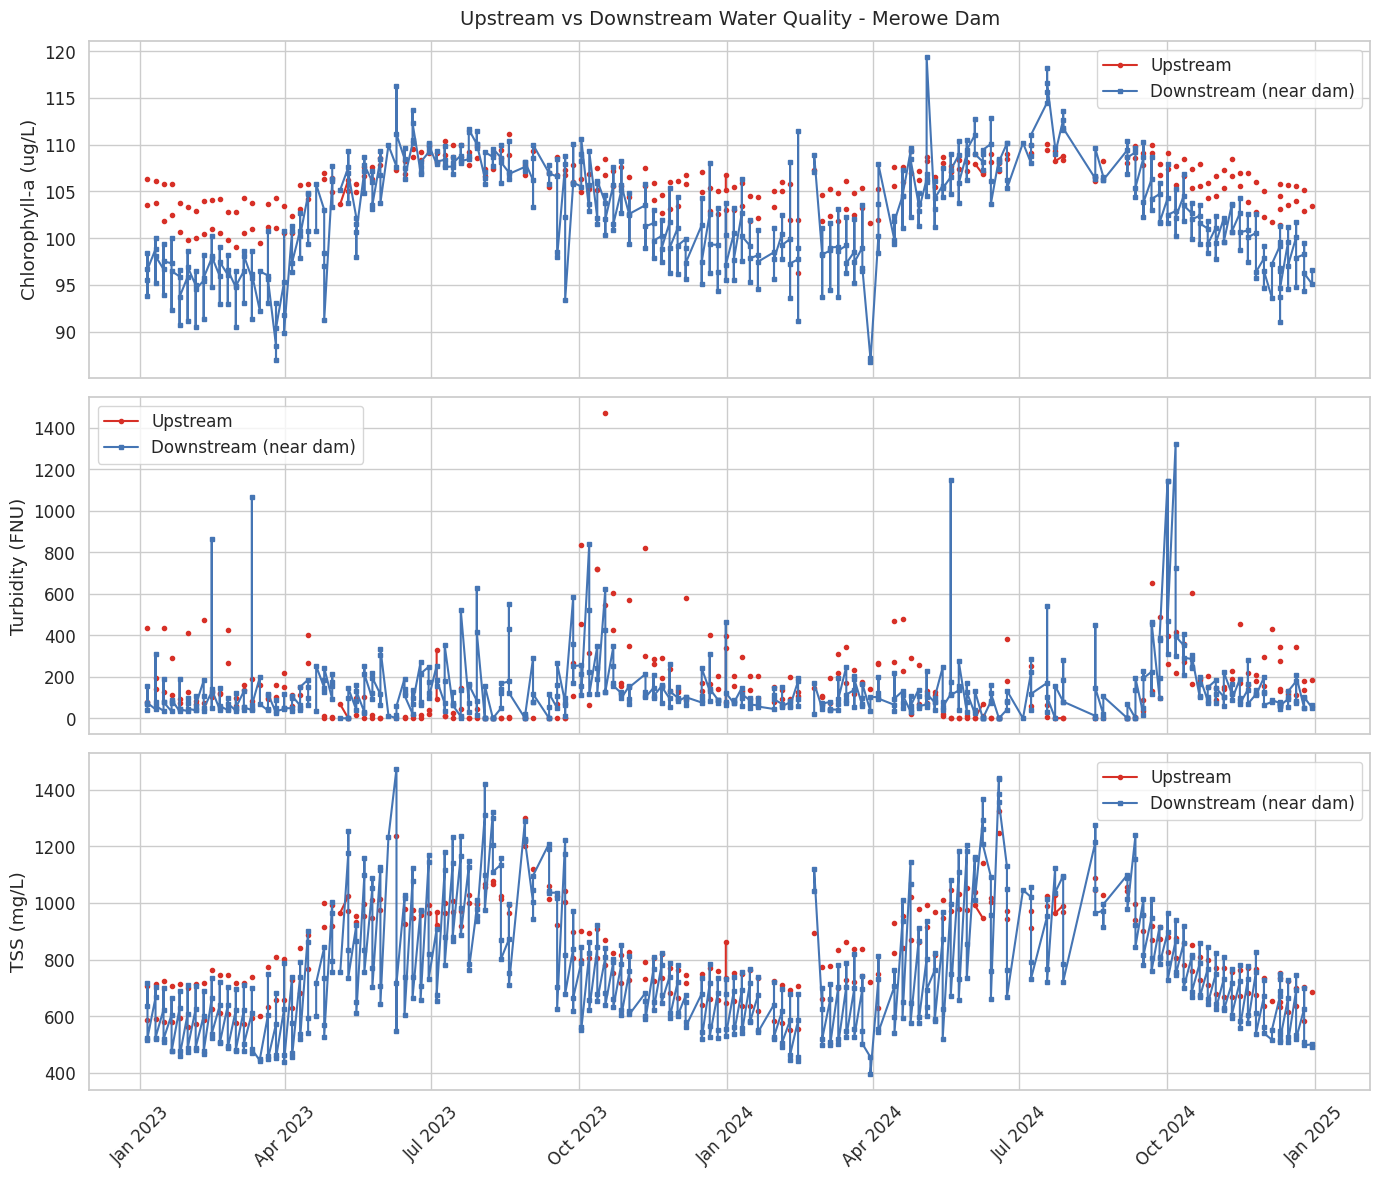

In [37]:
# Cell 25: Spatial Gradient Analysis - Upstream vs Downstream
# Split reservoir into zones by longitude

lon_mid = float(ds.lon.median())

upstream = ds.sel(lon=slice(lon_mid, None)).mean(dim=["lon", "lat"], skipna=True)
downstream = ds.sel(lon=slice(None, lon_mid)).mean(dim=["lon", "lat"], skipna=True)

up_df = upstream.to_dataframe().reset_index()
up_df["time"] = pd.to_datetime(up_df["time"])
down_df = downstream.to_dataframe().reset_index()
down_df["time"] = pd.to_datetime(down_df["time"])

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for ax, (param, label) in zip(axes, [
    ("Chlorophyll_a", "Chlorophyll-a (ug/L)"),
    ("Turbidity_FNU", "Turbidity (FNU)"),
    ("TSS", "TSS (mg/L)"),
]):
    ax.plot(up_df["time"], up_df[param], "o-", label="Upstream", color="#d73027", markersize=3)
    ax.plot(down_df["time"], down_df[param], "s-", label="Downstream (near dam)", color="#4575b4", markersize=3)
    ax.set_ylabel(label)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)

axes[0].set_title("Upstream vs Downstream Water Quality - Merowe Dam", fontsize=14, pad=12)
plt.tight_layout()
plt.savefig("15_upstream_vs_downstream.png", dpi=300, bbox_inches="tight")
plt.show()

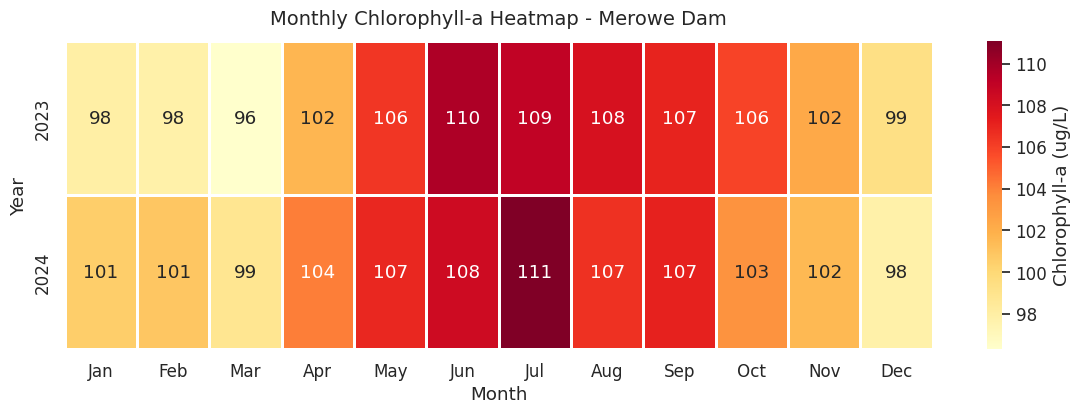

In [39]:
# Cell 26: Monthly Variability Heatmap (Calendar View)
ts_df["year"] = ts_df["time"].dt.year
ts_df["month_name"] = ts_df["time"].dt.strftime("%b")

pivot_chla = ts_df.groupby(["year", "month_name"])["Chlorophyll_a"].median().unstack()
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
pivot_chla = pivot_chla.reindex(columns=month_order)

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(pivot_chla, annot=True, fmt=".0f", cmap="YlOrRd",
            linewidths=1, ax=ax)
ax.collections[0].colorbar.set_label("Chlorophyll-a (ug/L)")
ax.set_title("Monthly Chlorophyll-a Heatmap - Merowe Dam", fontsize=14, pad=12)
ax.set_ylabel("Year")
ax.set_xlabel("Month")
plt.savefig("16_monthly_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

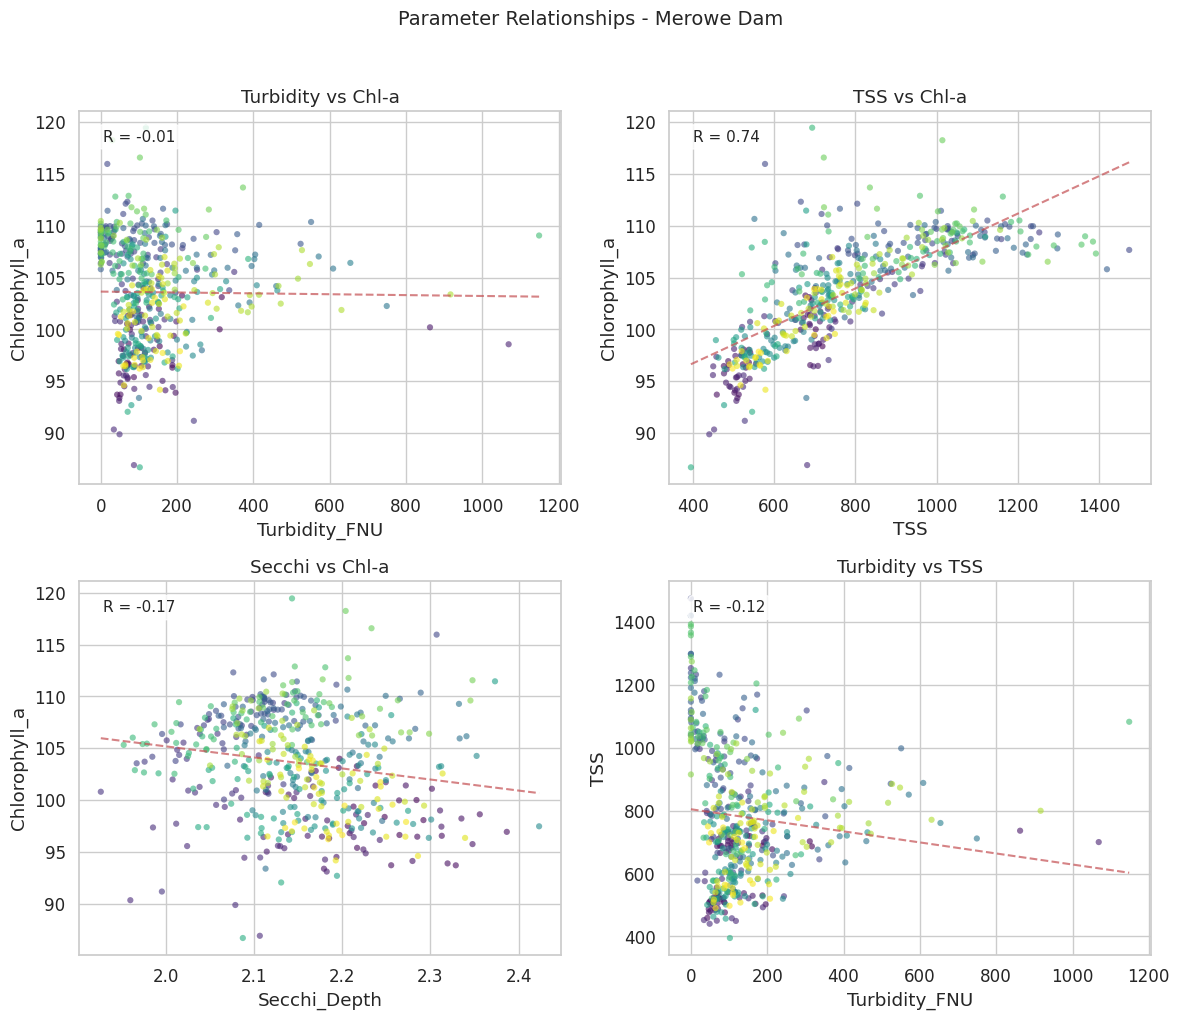

In [40]:
# Cell 27: Parameter Relationship Scatter Matrix
from matplotlib.colors import Normalize

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
scatter_data = ts_df.dropna(subset=["Chlorophyll_a", "Turbidity_FNU", "TSS", "Secchi_Depth"])

pairs = [
    (("Turbidity_FNU", "Chlorophyll_a"), "Turbidity vs Chl-a"),
    (("TSS", "Chlorophyll_a"), "TSS vs Chl-a"),
    (("Secchi_Depth", "Chlorophyll_a"), "Secchi vs Chl-a"),
    (("Turbidity_FNU", "TSS"), "Turbidity vs TSS"),
]

for ax, ((x, y), title) in zip(axes.flat, pairs):
    sc = ax.scatter(scatter_data[x], scatter_data[y],
                    c=scatter_data["time"].astype(np.int64),
                    cmap="viridis", alpha=0.6, s=20, edgecolors="none")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)

    # Add trendline
    mask = scatter_data[[x, y]].notna().all(axis=1)
    if mask.sum() > 2:
        z = np.polyfit(scatter_data.loc[mask, x], scatter_data.loc[mask, y], 1)
        p = np.poly1d(z)
        xline = np.linspace(scatter_data[x].min(), scatter_data[x].max(), 100)
        ax.plot(xline, p(xline), "r--", linewidth=1.5, alpha=0.7)
        r = np.corrcoef(scatter_data.loc[mask, x], scatter_data.loc[mask, y])[0, 1]
        ax.text(0.05, 0.95, f"R = {r:.2f}", transform=ax.transAxes, fontsize=11,
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.suptitle("Parameter Relationships - Merowe Dam", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("17_scatter_matrix.png", dpi=300, bbox_inches="tight")
plt.show()